Dataset, který jsem si pro tuto úlohu zvolila, je ze stránky https://www.kaggle.com/datasets/zalando-research/fashionmnist a jedná se o dataset plný obrázků o rozměru 28x28 pixelů. Dataset z této stránky je ale až moc velký, takže při trénovaní mi neustále padal kernel. Nepoužila jsem tedy celý dataset, ale pouze jeho část.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('train.csv')
data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,1,2,1,4,2,0,0,...,37,73,65,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,105,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,135,135,184,59,0,2,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,70,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,1,0,0,0,0,1,0,41,141,128,...,0,0,0,0,0,0,0,0,0,0
2396,0,0,0,0,0,0,0,0,1,2,...,175,198,173,0,0,1,0,0,0,0
2397,0,0,0,1,0,0,0,0,0,0,...,88,75,24,0,0,0,2,0,0,0
2398,0,0,0,0,0,0,0,0,0,105,...,129,129,145,74,0,0,0,0,0,0


Dataset neopsahuje žádné nullové hodnoty a zároveň jsou všechny hodnoty mezi 0 a 255, tedy ve správném formátu. Nemusíme tedy data upravovat.

In [2]:
data.info()
data.isna().sum().unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 14.4 MB


array([0])

In [3]:
(data.max() > 255).unique()

array([False])

In [4]:
(data.min() < 0).unique()

array([False])

### Vyobrazení obrázků

In [5]:
dX = data.drop(columns=['label'])
images = [dX.loc[i].array.reshape((28, 28)) for i in range(min(len(dX), 2))]

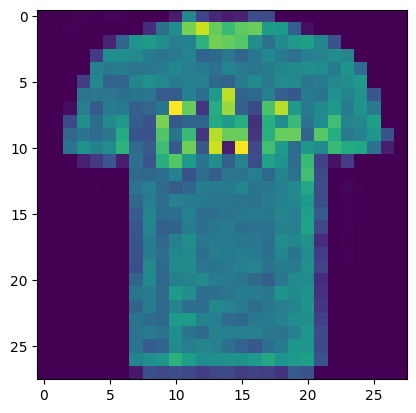

In [6]:
for img in images:
    plt.imshow(img)

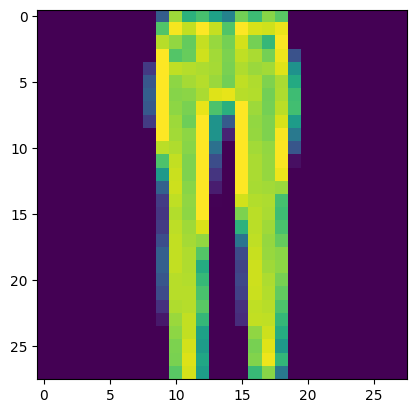

In [7]:
dX = data.drop(columns=['label'])
images = [dX.loc[i].array.reshape((28, 28)) for i in range(min(len(dX), 6))]
for img in images:
    plt.imshow(img)

In [8]:
data.shape

(2400, 785)

## Redukce dimenze

Jelikož se jedná o dataset s rozměry 2400 x 785, bude velmi obtížné tato data vyzualizovat v grafech, abychom mohli vidět, jak dané modely rozdělily tato data do shluků. Abychom si ulehčili práci, data nejprve standardizujeme, normalizujeme a následně využijeme PCA pro redukci dimenze - dimenze 2.

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
data = data.drop(columns='label')

In [11]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
import scipy.cluster.hierarchy as shc
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)
X_normalized = normalize(X_scaled)

In [12]:
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_scaled)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2'] # pojmenování nově získaných sloupců

### Vyzualizace shlukování pomocí dendrogramu

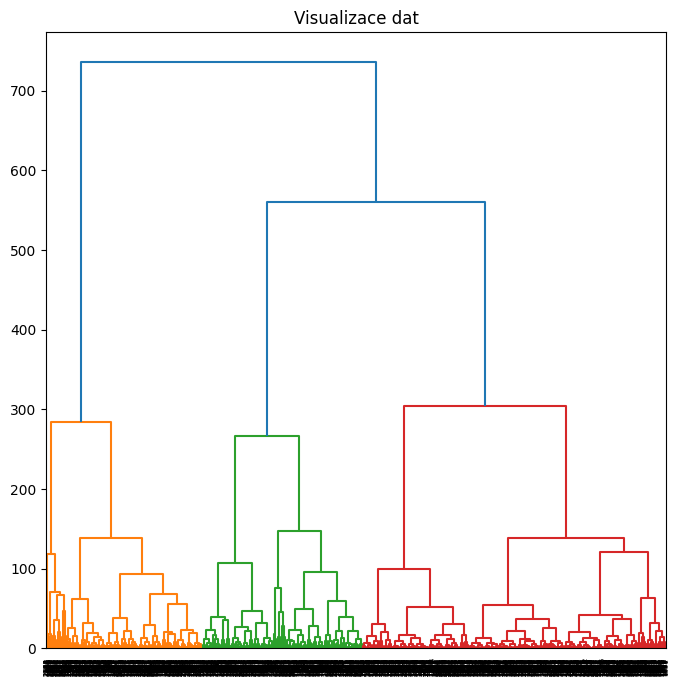

In [13]:
plt.figure(figsize =(8, 8))
plt.title('Visualizace dat')
Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward')))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data)
scaled = scaler.transform(data)

### Shlukování pomocí KMeans

Nejprve zjistíme optimální množství shluků pro daný dataset.

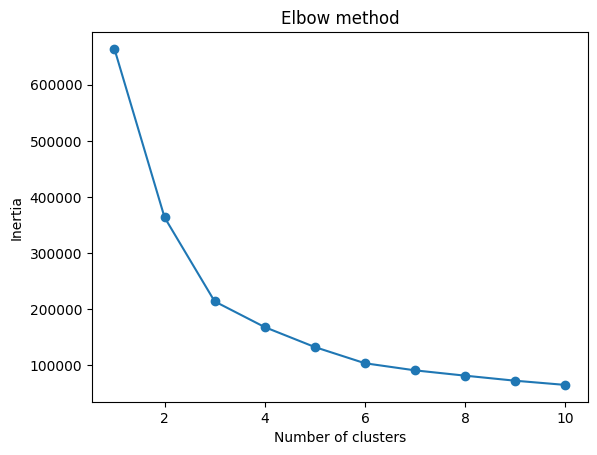

In [14]:
from sklearn.cluster import KMeans

inertia_arr = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_principal)
    inertia_arr.append(kmeans.inertia_)

plt.plot(range(1,11), inertia_arr, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

Pomocí Elbow metody jsme zjistili, že optimální je použití 3 shluků. Dále implementujeme model KMeans se 3mi shluky a zjistíme jeho silhoutte hodnotu.

In [15]:
kmeans = KMeans(n_clusters=3, init='k-means++',random_state=32)
kmeans.fit(X_principal)

KMeans(n_clusters=3, random_state=32)

In [16]:
from sklearn.metrics import silhouette_samples, silhouette_score
kmeans_average_score = silhouette_score(X_principal, kmeans.predict(X_principal))

In [17]:
print(kmeans_average_score)

0.48404463040139906


Jelikož je hodnota průměrné silhouette score kladná, jsou shluky dostatečně daleko od sebe. Čím blíž se hodnota blíží k 1, tím lepší.

### Agglomerative clustering

U Agglomerativního shlukování opět nejprve najdeme nejlepší množství shluků na základě silhoutte hodnoty - čím větší, tím lepší.

In [18]:
silhouette_scores = []

paramters = range(2,11)
for i in range(2,11):
    ac = AgglomerativeClustering(n_clusters = i)
    silhouette_scores.append(silhouette_score(X_principal, ac.fit_predict(X_principal)))

Text(0, 0.5, 'accuracy')

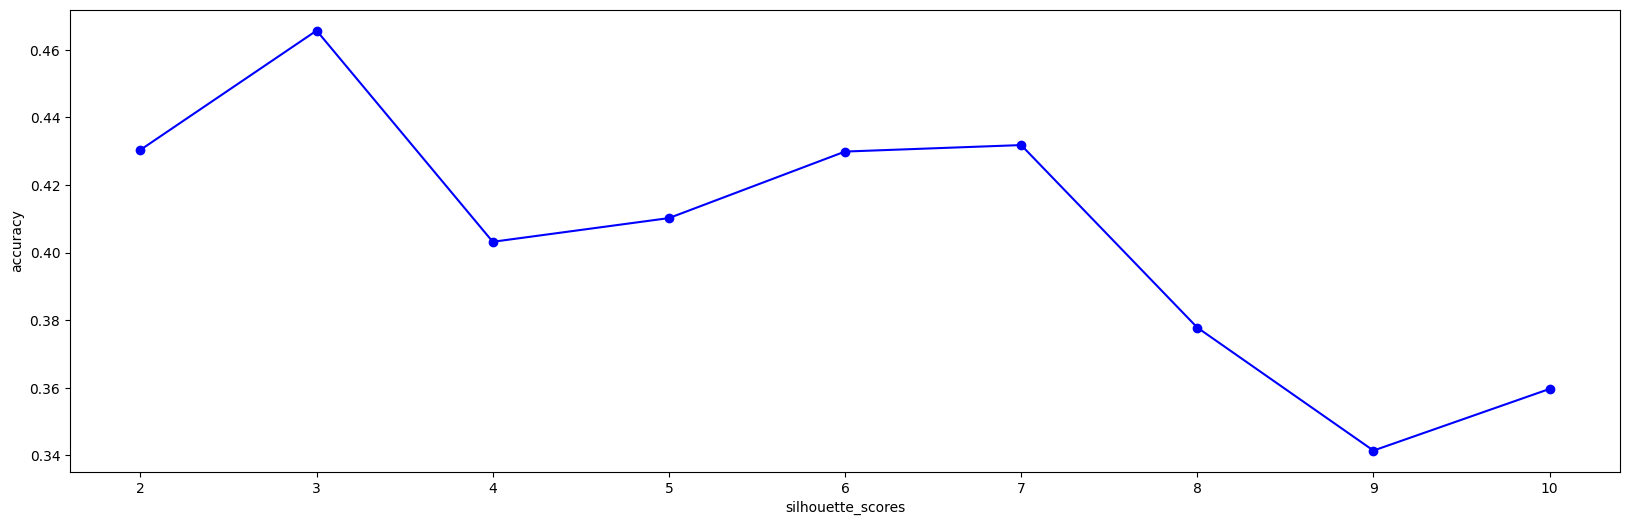

In [19]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,6))
plt.plot(paramters, silhouette_scores,'ob-')
plt.xlabel('silhouette_scores')
plt.ylabel('accuracy')

Protože je hodnota silhouette score největší pro 3 shluky, implujeme tedy model pro toto množství.

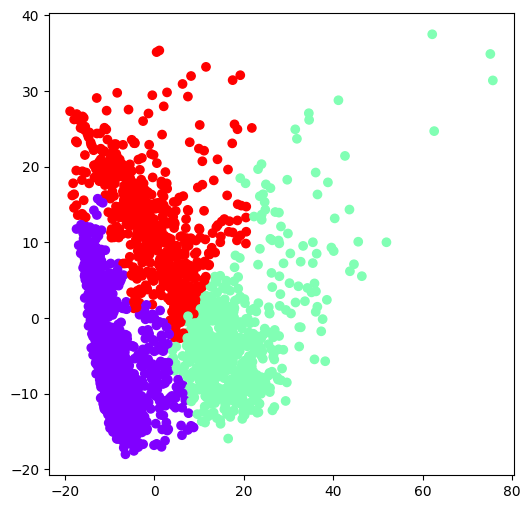

In [20]:
ac = AgglomerativeClustering(n_clusters = 3)
 
plt.figure(figsize =(6, 6))
plt.scatter(X_principal['P1'], X_principal['P2'], c = ac.fit_predict(X_principal), cmap ='rainbow')
plt.show()

In [21]:
print(silhouette_score(X_principal, ac.fit_predict(X_principal)))

0.4656534783038497


Metoda KMeans v tomto případě lépe rozděluje data do shluků => dochází k o lehce větší hodnotě silhoutte score než agglomerativní shlukování